# Random Forest - Previsão de Séries Temporais

## Importar as bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

## Importar a base de dados

In [ ]:
original_dataset = pd.read_csv('comercial_valor.csv', sep=';')
original_dataset.head()

,Ano,Mes,Venda
0,2015,1,2374481
1,2015,2,2037942
2,2015,3,2495664
3,2015,4,2483449
4,2015,5,3895269


In [ ]:
original_dataset.Ano.value_counts()

2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023     4
Name: Ano, dtype: int64

In [ ]:
# tratando os dados da covid
data_ini = datetime.date(2020, 3, 1)
data_fin = datetime.date(2021, 4, 1)

for i in original_dataset.index:

  data_aux = datetime.date(original_dataset.loc[i, 'Ano'], original_dataset.loc[i, 'Mes'], 1)

  if data_aux >= data_ini and data_aux <= data_fin:

    if data_aux == data_ini or data_aux == data_ini + pd.DateOffset(months=1):

      original_dataset.loc[i, 'Venda'] = (original_dataset.loc[i-12, 'Venda'] + original_dataset.loc[i+24, 'Venda'])/2

    else:

      original_dataset.loc[i, 'Venda'] = (original_dataset.loc[i-12, 'Venda'] + original_dataset.loc[i+12, 'Venda'])/2



<ipython-input-12-4bd5d0d19d82>:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if data_aux == data_ini or data_aux == data_ini + pd.DateOffset(months=1):


In [ ]:
dataset = original_dataset.copy()
dataset["data"] = original_dataset["Mes"].astype(str) + '-' + original_dataset["Ano"].astype(str)
dataset.head()

,Ano,Mes,Venda,data
0,2015,1,2374481.0,1-2015
1,2015,2,2037942.0,2-2015
2,2015,3,2495664.0,3-2015
3,2015,4,2483449.0,4-2015
4,2015,5,3895269.0,5-2015


In [ ]:
dataset["Venda"]=dataset["Venda"].astype(int)

In [ ]:
dataset.index = dataset['data']
dataset = dataset.drop(columns=['Ano', 'Mes', 'data'])
dataset.head()

,Venda
data,
1-2015,2374481
2-2015,2037942
3-2015,2495664
4-2015,2483449
5-2015,3895269


In [ ]:
dataset.shape

(100, 1)

## Visualizar série histórica

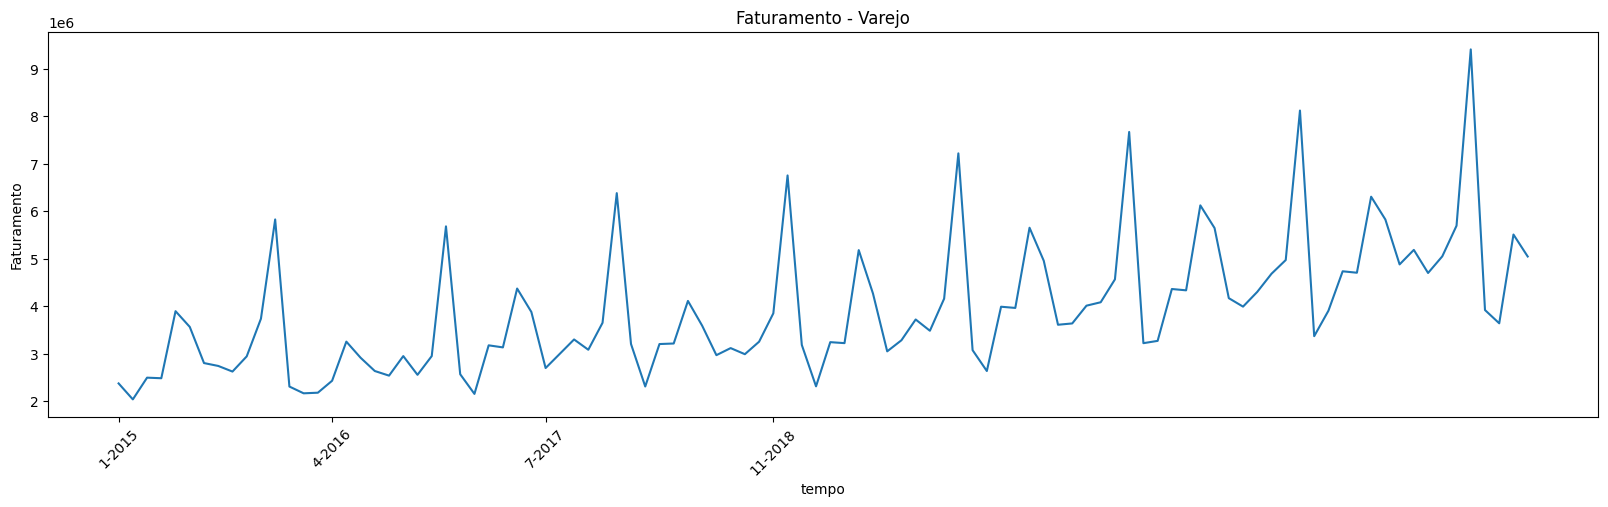

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(dataset)
plt.xlabel("tempo")
plt.ylabel("Faturamento")
plt.title("Faturamento - Varejo")
plt.xticks([0,15,30,46], rotation=45) # coloca somente 4 valores no eixo x e rotaciona 45 graus por questões de visualização
plt.show()

Comportamento anual

In [ ]:
len(original_dataset.Ano.value_counts())

9

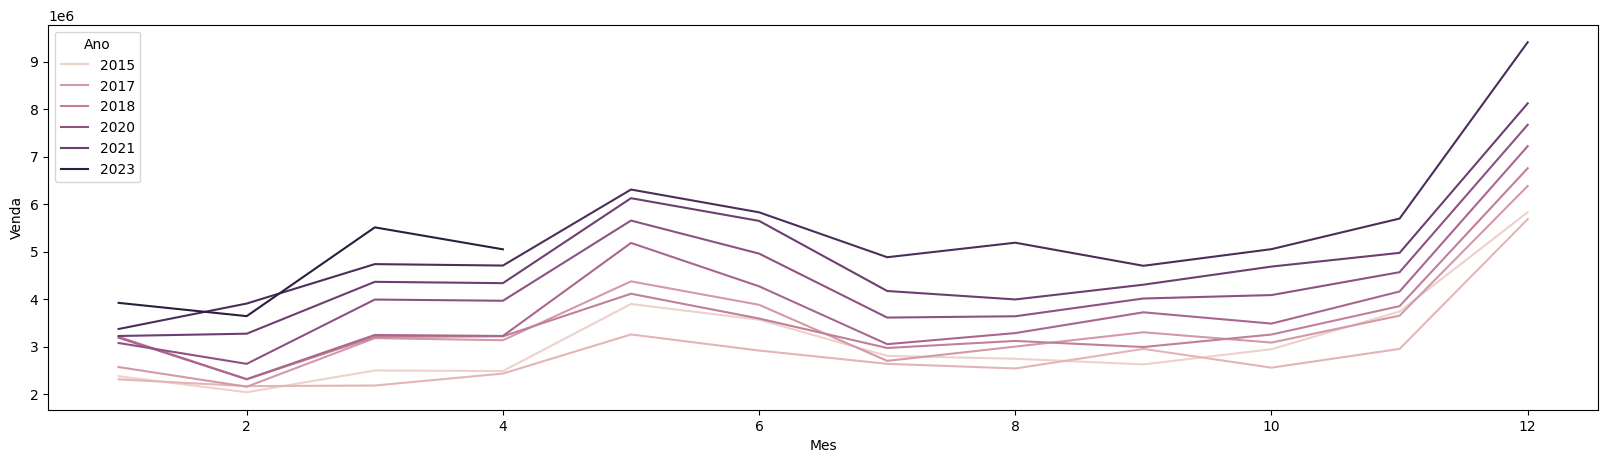

In [ ]:
plt.figure(figsize=(20,5))
sns.lineplot(x='Mes', y='Venda', hue='Ano', data=original_dataset)
plt.show()

Autocorrelation (ACF): sumariza de forma gráfica a força do relacionamentro entre observações da série temporal (direta e indiretamente). O que está dentro da área em azul não é estatisticamente significante.

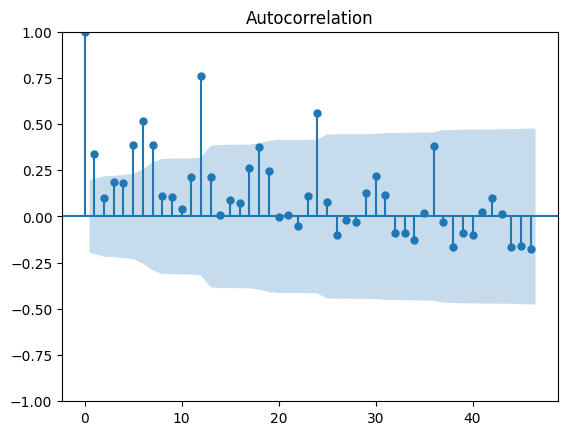

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(dataset['Venda'], lags=46)
plt.show()

PartialAutocorrelation (PACF): relação direta

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


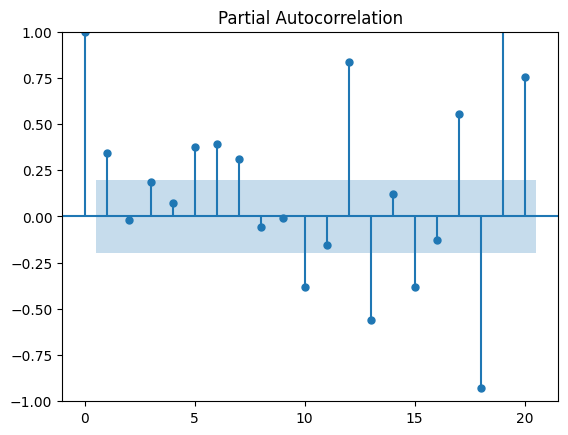

In [ ]:
plot_pacf(dataset['Venda']);

## Criar janelamento

In [ ]:
window = 12
dataSize = len(dataset)
X = []
y = []
for i in range(window, dataSize):
    X.append(dataset.iloc[i-window:i, 0])
    y.append(dataset.iloc[i, 0])
X, y = np.array(X), np.array(y)

In [ ]:
print(X.shape)
print(y.shape)

(88, 12)
(88,)


In [ ]:
X[0:5]

array([[2374481, 2037942, 2495664, 2483449, 3895269, 3564149, 2802805,
        2742354, 2623923, 2943485, 3736900, 5826404],
       [2037942, 2495664, 2483449, 3895269, 3564149, 2802805, 2742354,
        2623923, 2943485, 3736900, 5826404, 2308665],
       [2495664, 2483449, 3895269, 3564149, 2802805, 2742354, 2623923,
        2943485, 3736900, 5826404, 2308665, 2166032],
       [2483449, 3895269, 3564149, 2802805, 2742354, 2623923, 2943485,
        3736900, 5826404, 2308665, 2166032, 2178929],
       [3895269, 3564149, 2802805, 2742354, 2623923, 2943485, 3736900,
        5826404, 2308665, 2166032, 2178929, 2430697]])

In [ ]:
y[0:5]

array([2308665, 2166032, 2178929, 2430697, 3254090])

## Separar em treino e teste

In [ ]:
import random
np.random.seed(0) #semente inicial (reprodução de resultados)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.1)

# imprimir
x_train[0:5]

array([[4704635, 6305053, 5825140, 4879814, 5185531, 4699384, 5049963,
        5694099, 9406091, 3918910, 3639793, 5508656],
       [2742354, 2623923, 2943485, 3736900, 5826404, 2308665, 2166032,
        2178929, 2430697, 3254090, 2915261, 2635555],
       [3176041, 3132748, 4371818, 3878522, 2698141, 2998510, 3299859,
        3083145, 3650376, 6380094, 3204330, 2309764],
       [3083145, 3650376, 6380094, 3204330, 2309764, 3203279, 3214602,
        4111058, 3589210, 2969370, 3117917, 2989596],
       [3963531, 5651748, 4955970, 3609411, 3637029, 4010929, 4083072,
        4565089, 7668172, 3221612, 3270088, 4361807]])

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(79, 12)
(79,)
(9, 12)
(9,)


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(random_state=0)
regressor.fit(x_train, y_train);

## Utilizar modelo treinado para fazer previsões na base de teste (um passo à frente)

In [ ]:
y_pred = regressor.predict(x_test)
y_pred[0:5]

array([2876340.72, 2507093.98, 4596103.6 , 3586783.89, 3580995.48])

In [ ]:
y_pred.shape

(9,)

## Calcular métricas de erro

Resultados de Teste
RMSE:  462675.7060512786
MSE:  214068808970.0492
MAPE:  12.595092204896552 %
R2:  0.8407143194182457


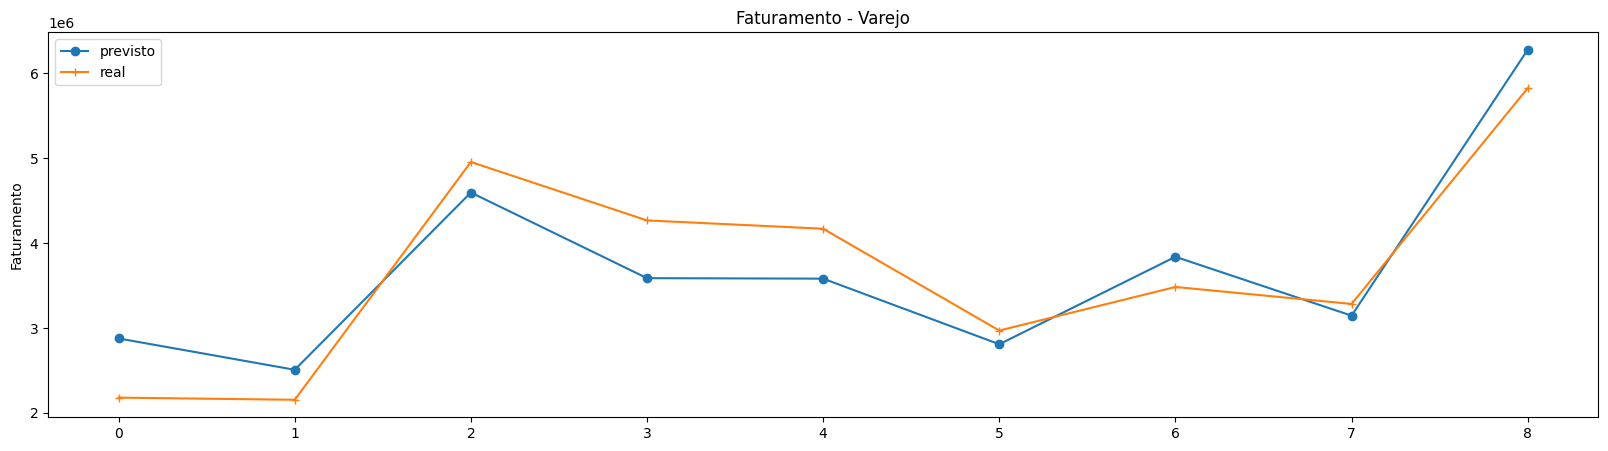

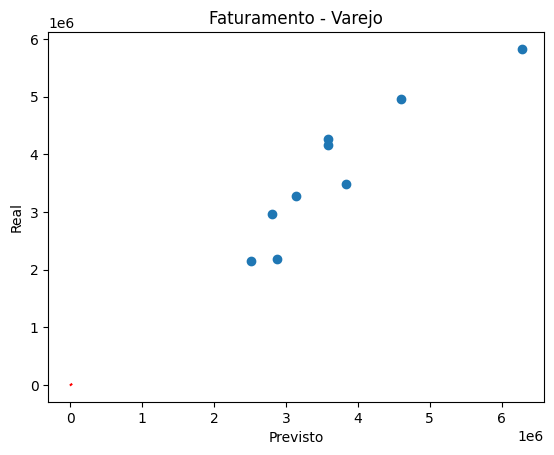

In [ ]:
def evaluate(y_test, y_pred):
  import math
  from sklearn.metrics import mean_squared_error
  rmse = math.sqrt(mean_squared_error(y_test, y_pred))
  print('RMSE: ', rmse)

  mse = mean_squared_error(y_test, y_pred)
  print('MSE: ',mse)

  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
  print('MAPE: ',mape, '%')

  from sklearn.metrics import r2_score
  r2 = r2_score(y_test, y_pred)
  print('R2: ', r2)

  # Gráfico 1
  plt.figure(figsize=(20,5))
  plt.plot(y_pred, label='previsto', marker='o')
  plt.plot(y_test, label='real', marker='+')
  plt.ylabel("Faturamento")
  plt.title("Faturamento - Varejo")
  plt.legend()
  plt.show()

  # Gráfico 2
  plt.scatter(y_pred,y_test)
  plt.ylabel("Real")
  plt.xlabel("Previsto")
  plt.title("Faturamento - Varejo")

  x = [5000.0, 14500.0]
  plt.plot(x, x, color='red'); # reta onde y=x (modelo perfeito)

  plt.show()

print('Resultados de Teste')
evaluate(y_test, y_pred)

## Avaliar Treino

RMSE:  172736.3664709818
MSE:  29837852301.597324
MAPE:  3.2955926537101847 %
R2:  0.9852200048934532


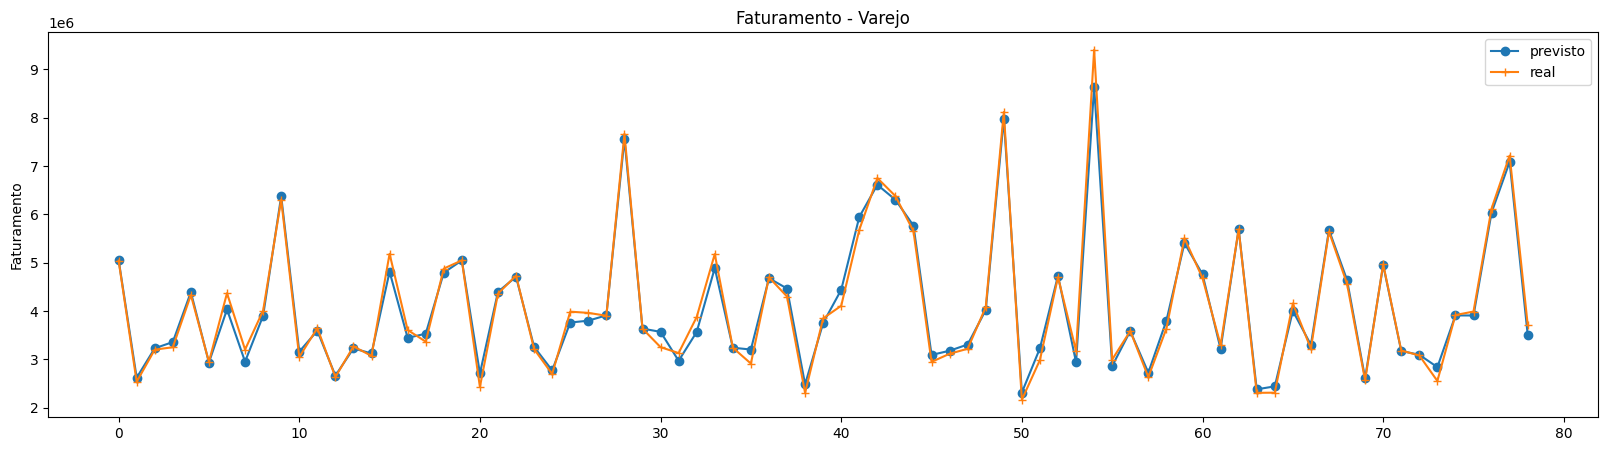

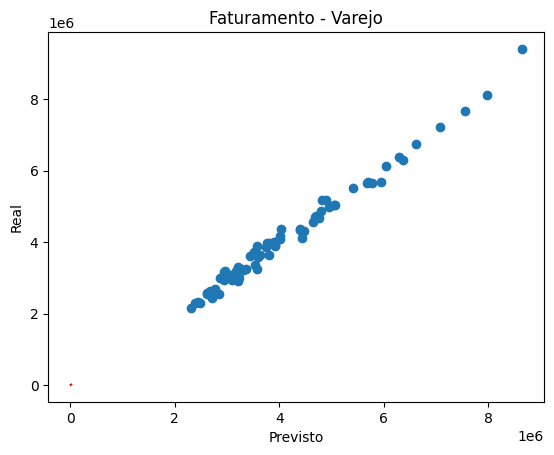

In [ ]:
y_pred_train = regressor.predict(x_train)
evaluate(y_train, y_pred_train)

RMSE:  462675.7060512786
MSE:  214068808970.0492
MAPE:  12.595092204896552 %
R2:  0.8407143194182457


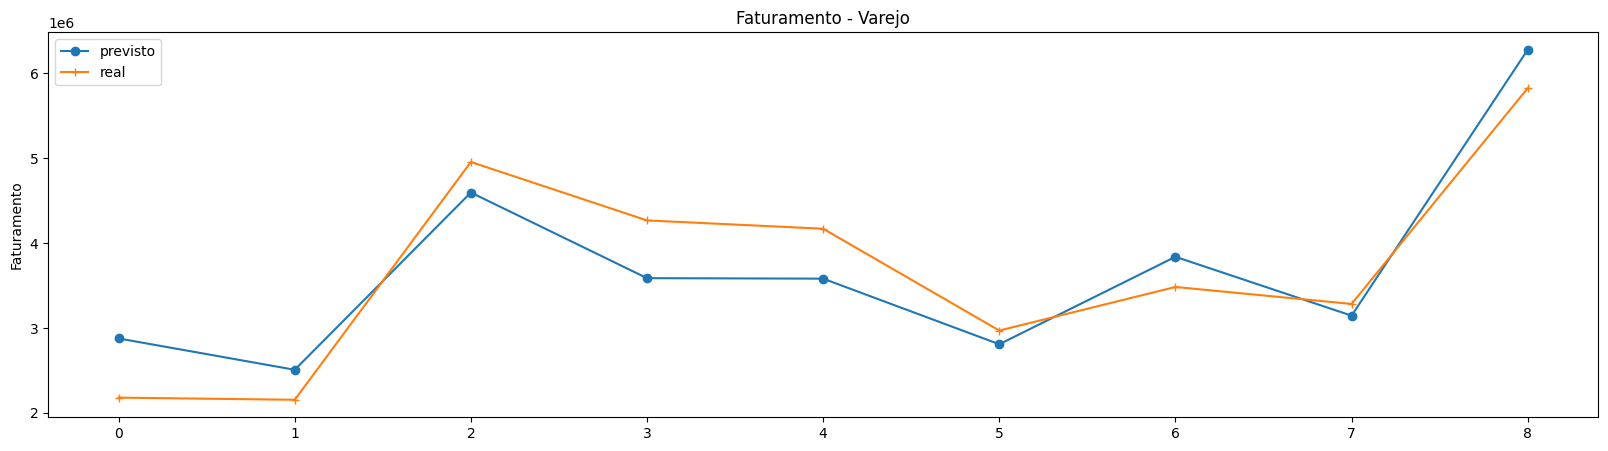

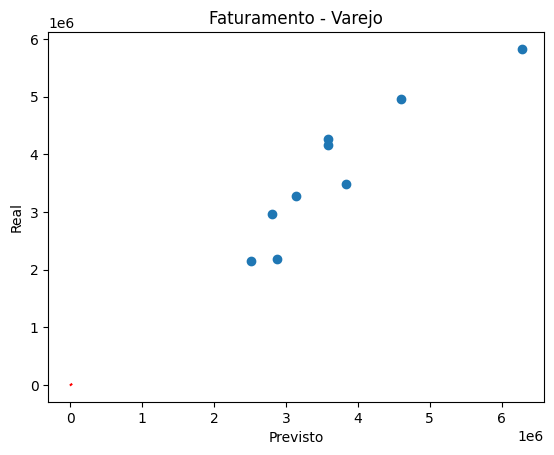

In [ ]:
y_pred_test = regressor.predict(x_test)
evaluate(y_test, y_pred_test)

## Prever mais passos à frente

OBS: tenha em conta que o modelo é 'one step ahead'. Ao prever mais passos à frente utilizando a própria previsão, estaremos propagando cada vez mais erro!

### Exercício 1: Utilize o modelo treinado para fazer a previsão de 1 passo à frente

In [ ]:
lag = dataset.iloc[dataSize-window:dataSize,0].values
lag

array([6305053, 5825140, 4879814, 5185531, 4699384, 5049963, 5694099,
       9406091, 3918910, 3639793, 5508656, 5046194])

In [ ]:
lag.shape

(12,)

In [ ]:
lag = lag.reshape(1, -1)
lag.shape

(1, 12)

In [ ]:
regressor.predict(lag)

array([7023654.72])

### Exercício 2: Utilize o modelo treinado para fazer a previsão de 12 passos à frente

In [ ]:
timesteps_to_predict = 12
lag = dataset.iloc[dataSize-window:dataSize,0].values
lag = lag.reshape(1, -1)

In [ ]:
predictions = []
for timestep in range(timesteps_to_predict):
  prediction = regressor.predict(lag)
  predictions.append(prediction)

  lag = lag[0, 1:window]
  lag = np.append(lag, prediction[0])
  lag = lag.reshape(1, -1)

In [ ]:
predictions

[array([7023654.72]),
 array([6695267.82]),
 array([6159906.5]),
 array([5698500.46]),
 array([4913718.7]),
 array([6087088.73]),
 array([6366462.79]),
 array([8553976.6]),
 array([3843185.44]),
 array([3857502.9]),
 array([6406700.35]),
 array([5679430.63])]

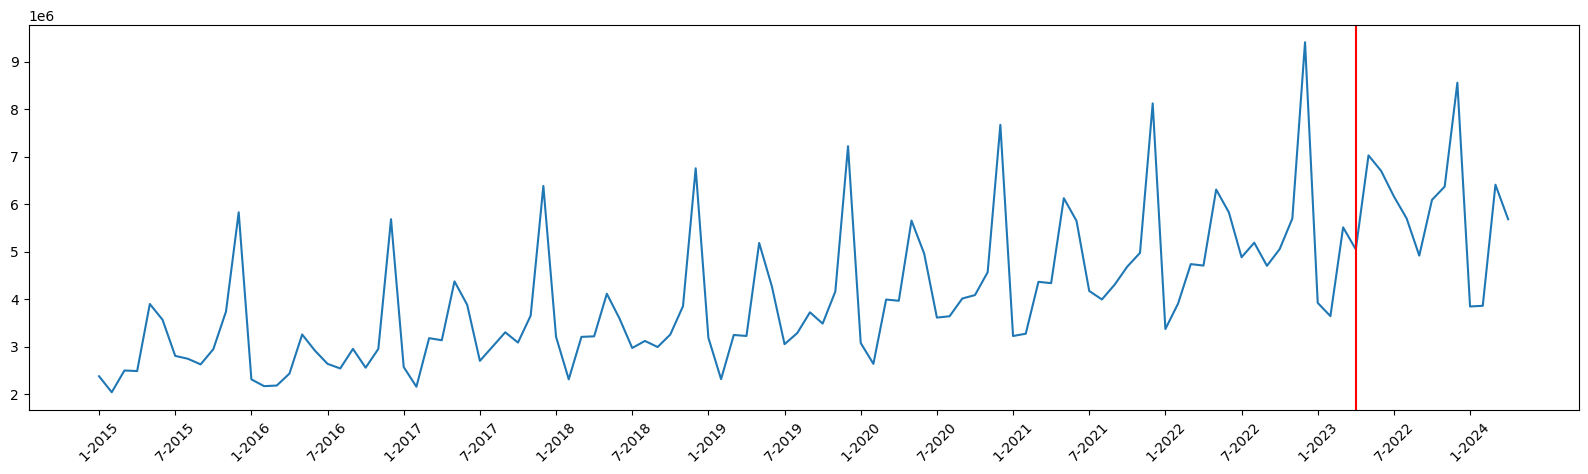

In [ ]:
plt.figure(figsize=(20, 5))
all_data = np.vstack((dataset, predictions))
plt.plot(all_data)

# Datas no eixo x
labels = np.append(dataset.index, [i.replace('3','4') for i in dataset.iloc[dataSize-window:dataSize,0].index])
plt.xticks(ticks=range(0, len(labels), 6), labels=labels[range(0, len(labels), 6)], rotation=45)

# início das previsões
plt.axvline(len(dataset)-1, color='red')
plt.annotate('Previsões', (130,6000))

plt.show()